In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Sample rate and recording length
fs = 40000
tlen = 60

In [6]:
def dB(x):
    return 10.0*np.log10(x)

In [7]:
def gaussian(x, a):
    arg = -0.5*((x-a[0])/a[1])**2
    return a[2]*np.exp(arg)+a[3]

In [8]:
def residual(a, x, y):
    return y-gaussian(x, a)

In [9]:
d = np.fromfile("/tmp/pll.raw", dtype=np.complex64, count=fs*tlen)

In [10]:
# Number of channels and sub-integrations
nchan = 2048
nsub = len(d)//nchan

In [102]:
# Compute power spectra
spec = np.fft.fftshift(np.absolute(np.fft.fft(d[:nsub*nchan].reshape(-1, nchan), n=nchan))**2)

In [103]:
# Average
avg_spec = np.sum(spec, axis=0)

In [104]:
# Frequency axis
freq = np.fft.fftshift(np.fft.fftfreq(nchan, d=1.0/fs))

In [ ]:
# Data selection
c = np.abs(freq+500)<2000
cfit = np.abs(freq+1000)<500

In [11]:
# Perform Gaussian fit
p = [-1000, 100, 200, -14]
q, cov_q, infodict, mesg, ier = scipy.optimize.leastsq(residual, p, args=(freq[cfit], dB(avg_spec[cfit])), full_output=1)

NameError: name 'q' is not defined

[-1.03607534e+03 -1.17932375e+02  7.14403917e-01 -1.37271329e+01]


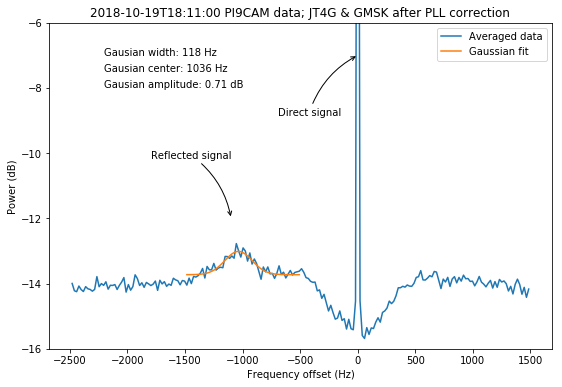

In [110]:
# Generate plot
plt.figure(figsize=(9, 6))
plt.plot(freq[c], dB(avg_spec[c]), label="Averaged data")
plt.plot(freq[cfit], gaussian(freq[cfit], q), label="Gaussian fit")
plt.xlabel("Frequency offset (Hz)")
plt.ylabel("Power (dB)")
plt.annotate("Reflected signal",
            xy=(-1100, -12), xycoords='data',
            xytext=(-80, 60), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-.2"))
plt.annotate("Direct signal",
            xy=(0, -7.0), xycoords='data',
            xytext=(-80, -60), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-.2"))
plt.text(-2200, -7.0, "Gausian width: %.0f Hz"%np.abs(q[1]))
plt.text(-2200, -7.5, "Gausian center: %.0f Hz"%np.abs(q[0]))
plt.text(-2200, -8.0, "Gausian amplitude: %.2f dB"%np.abs(q[2]))
plt.ylim(-16,-6)
plt.title("2018-10-19T18:11:00 PI9CAM data; JT4G & GMSK after PLL correction")
plt.legend()
plt.savefig("jt4g_pll.png")